# Test and Visualize Results

In [1]:
import json
import ray
from ray import tune
from model import RNN,  Base
from utils import plot_data, get_input_data, get_dataloader, get_input_data_1D
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Utility funtions

In [2]:
def get_config(json_config_path):
    with open(json_config_path, 'r') as fp:
        best_config = json.load(fp)
    return best_config

def load_model(params):
    print(f'Loading {params["model_name"]} model...')
    model = Base(input_size=params['input_size'], 
                hidden_size = params["hidden_size"],
                num_layers = params["num_layers"],
                output_size=1 if params['data_dim'] == 1 else 3,
                model = params['model_name'])

    chkpoints_list = [i for i in os.listdir(params['dir']) if i.startswith("checkpoint")]
    last_checkpoint = sorted(chkpoints_list, key=lambda x: int(x.split('_')[-1]))[-1]
    
    print(f'Loading model: {last_checkpoint} from {params["dir"]}...')
    chkpoint_state_dict, optim_state = torch.load(os.path.join(params['dir'], f'{last_checkpoint}', "checkpoint"))
    model.load_state_dict(chkpoint_state_dict)
    return model

In [3]:
def test_accuracy(net, test_loader, device="cpu"):
    
    net.to(device)
    criterion = nn.MSELoss()
    loss = 0
    # total = 0
    test_pred = []
    with torch.no_grad():
        for data in test_loader:
            input, labels = data
            input, labels = input.to(device), labels.to(device)
            outputs, _ = net(input)
            # _, predicted = torch.max(outputs.data, 1)
            loss += criterion(outputs, labels).cpu().numpy()
            test_pred.append(outputs.cpu().numpy())
    return loss / len(test_loader), np.concatenate(np.array(test_pred), axis=0)


In [4]:
def get_mse(pred, labels):
    criterion = nn.MSELoss()
    return criterion(torch.tensor(pred).clone().detach() , torch.tensor(labels)).item()


In [5]:
def get_all_mse(pred, labels):
    all_losses = []
    for i in range(pred.shape[1]): # output size 
        all_losses.append(get_mse(pred[:, i], labels[:, i]))
    return all_losses, get_mse(pred[:, 0], labels[:, 0]) # return mse for x, y, theta and total mse


In [6]:
def show_plots(nn_preds, kalman_pred, gt, lim = -1):
    dim = nn_preds.shape[1]
    plt.figure(figsize=(20, 10))
    if dim == 3:
        plt.subplot(3, 1, 1)
        plt.plot(nn_preds[:lim, 0], label='X pred')
        plt.plot(gt[:lim, 0], label='X true')
        plt.plot(kalman_pred[:lim, 0], label='X kalman')
        plt.legend(['X pred', 'X true', 'X kalman'])

        plt.subplot(3, 1, 2)
        plt.plot(nn_preds[:lim, 1], label='Y pred')
        plt.plot(gt[:lim, 1], label='Y true')
        plt.plot(kalman_pred[:lim, 1], label='Y kalman')
        plt.legend(['Y pred', 'Y true', 'Y kalman'])

        plt.subplot(3, 1, 3)
        plt.plot(nn_preds[:lim, 2], label='Theta pred')
        plt.plot(gt[:lim, 2], label='Theta true')
        plt.plot(kalman_pred[:lim, 2], label='Theta kalman')
        plt.legend(['Theta pred', 'Theta true', 'Theta kalman'])
    elif dim==1:
        plt.plot(nn_preds[:lim], label='NN pred')
        plt.plot(gt[:lim], label='GT')
        plt.plot(kalman_pred[:lim], label='Kalman pred')
        plt.legend(['NN pred', 'GT', 'Kalman Pred'])
    else:
        # invalid dim error
        raise ValueError("Invalid dim")
    
    # plt.legend()
    plt.show()


In [23]:
def get_csv_results(eval_csv_dir, params):
    config = get_config(json_config_path)
    config.update(params)

    model = load_model(config)

    # test_df = pd.read_csv(EVAL_DATA_DIR)
    if data_dim == 2:
        test_dataset = get_input_data(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)
    else:
        test_dataset = get_input_data_1D(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)
    test_loader = get_dataloader(test_dataset[0], test_dataset[1], batch_size=config['batch_size'])

    loss, nn_preds = test_accuracy(model, test_loader, device='cpu')
    print(f"Test loss: {loss}")

    kalman_pred = np.array(test_dataset[2])


    nn_loss_dims, nn_loss = get_all_mse(nn_preds, test_dataset[1])
    print(f"NN MSE: {nn_loss_dims}, {nn_loss}")
    kf_loss_dims, kf_loss = get_all_mse(kalman_pred, test_dataset[1])
    print(f"KF MSE: {kf_loss_dims}, {kf_loss}")

    show_plots(nn_preds, kalman_pred, test_dataset[1], lim=1000)
    return kf_loss_dims, kf_loss, nn_loss_dims, nn_loss

## Action

### LSTM

In [20]:
data_dim = 2
model_name = "LSTM"
# eval_csv_dir = "data/1D/evaluation_data/mnst_2_lnstd_0.1.csv"
eval_dir_path = f"data/{data_dim}D/evaluation_data"
eval_csv_dir = os.path.join(eval_dir_path, os.listdir(eval_dir_path)[0])
# json_config_path = '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_1D/best_config_RNN.json'
json_config_path = f'/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_{data_dim}D/best_config_{model_name}.json'


params = {
    "batch_size": 100,
    "model_name": model_name,
    "input_size": 19 if data_dim == 2 else 9,
    "output_size": 3 if data_dim == 2 else 1,
    'model_name': model_name,
    'data_dim': data_dim,
}

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading LSTM model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-03_22-50-55/train_ray_725d5_00010_10_lr=0.0002,num_layers=2,sequence_length=28_2023-05-03_23-04-58...
Test loss: 1.279604751084532
NN MSE: [2.1526223852546362, 0.8563012458332278, 0.8298905960278955], 2.1526223852546362
KF MSE: [0.5758663749764509, 0.29061729301393313, 0.8236696571148735], 0.5758663749764509


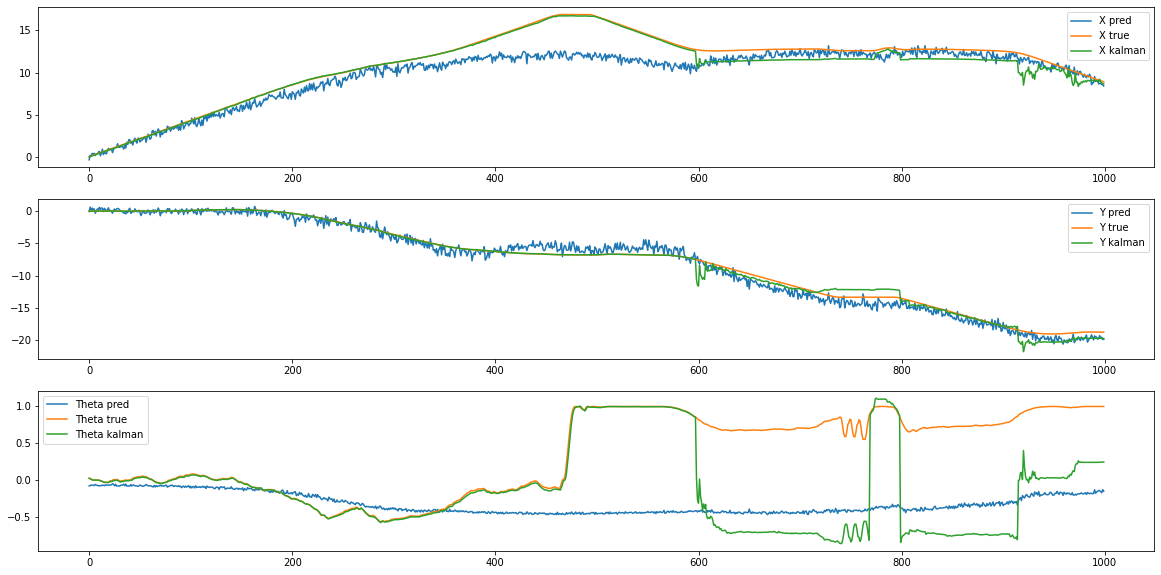

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading LSTM model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-03_22-50-55/train_ray_725d5_00010_10_lr=0.0002,num_layers=2,sequence_length=28_2023-05-03_23-04-58...
Test loss: 54.13862917306168
NN MSE: [17.439380740165237, 144.83613553338856, 0.14037331109947357], 17.439380740165237
KF MSE: [17.77573435384391, 143.82167838172418, 0.10664544740788669], 17.77573435384391


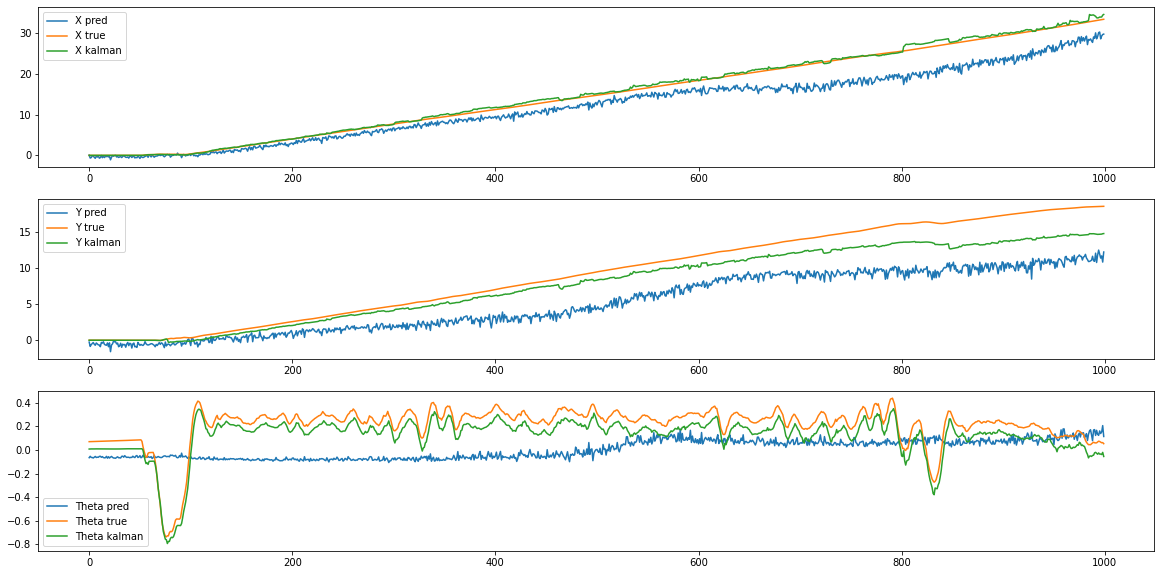

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading LSTM model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-03_22-50-55/train_ray_725d5_00010_10_lr=0.0002,num_layers=2,sequence_length=28_2023-05-03_23-04-58...
Test loss: 76.4718892417456
NN MSE: [113.90577454697576, 114.36590825323671, 1.1439837127372492], 113.90577454697576
KF MSE: [14.212498990049044, 38.88064932965862, 0.10207701358337826], 14.212498990049044


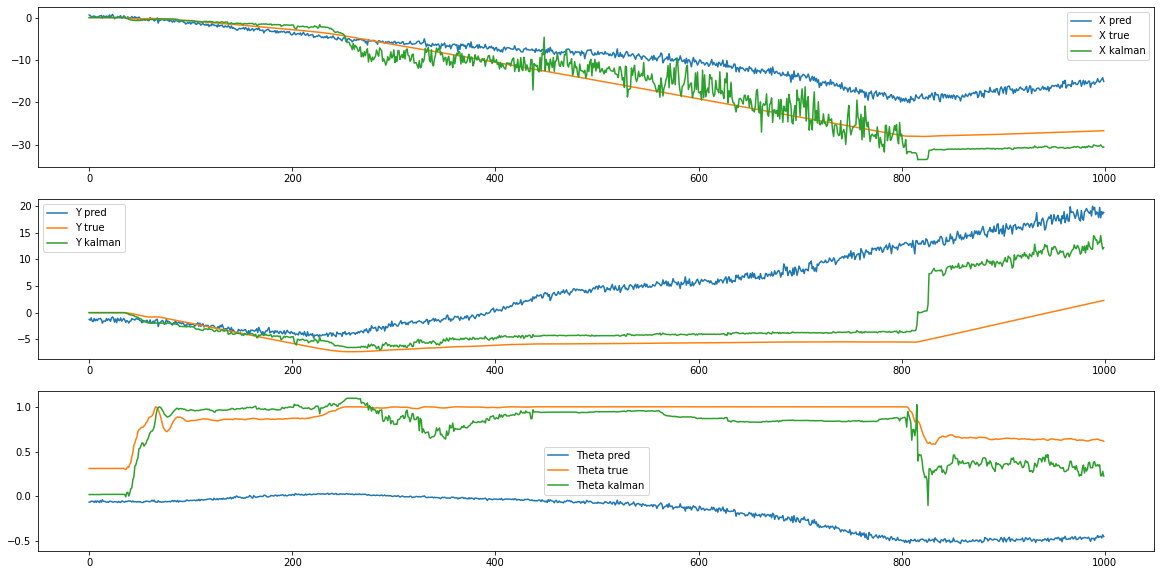

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading LSTM model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-03_22-50-55/train_ray_725d5_00010_10_lr=0.0002,num_layers=2,sequence_length=28_2023-05-03_23-04-58...
Test loss: 0.5745294703543187
NN MSE: [0.8176904752114095, 0.5006022677386507, 0.4052956614515164], 0.8176904752114095
KF MSE: [0.19424027079421535, 0.18997303008912253, 0.47563832569416964], 0.19424027079421535


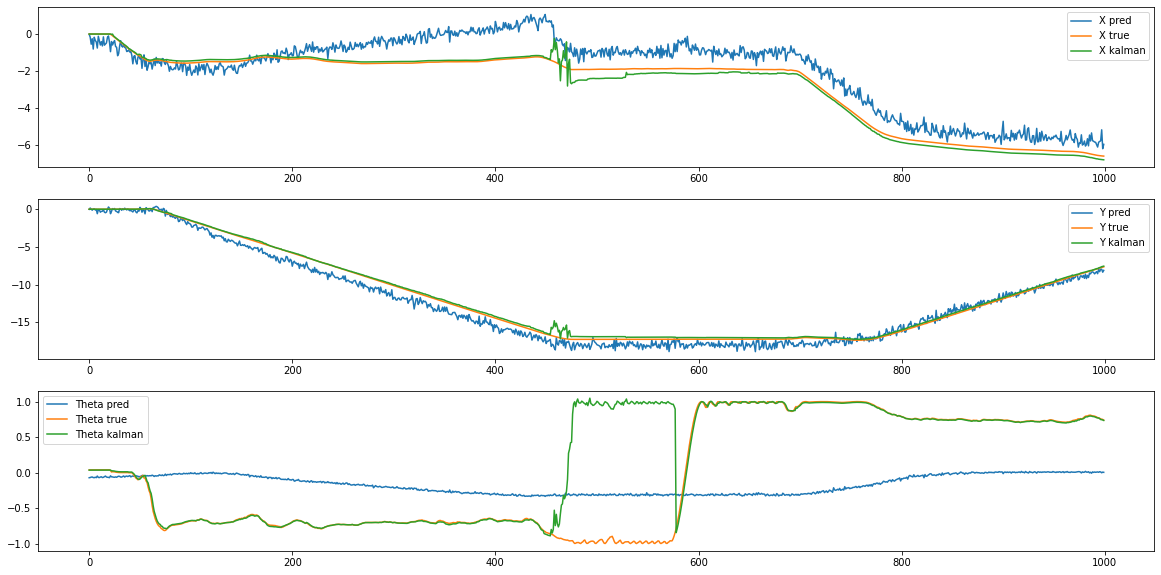

In [22]:

kalman_mse_x = []
kalman_mse_y = []
kalman_mse_theta = []

nn_mse_x = []
nn_mse_y = []
nn_mse_theta = []

kalman_mse_total = []
nn_mse_total = []

test_set = []
test_model = []

for csv_name in os.listdir(eval_dir_path):
    csv_dir = os.path.join(eval_dir_path, csv_name)
    print(f"CSV: {eval_csv_dir}")
    # get_csv_results(csv_dir)

    kf_loss_dims, kf_loss, nn_loss_dims, nn_loss = get_csv_results(csv_dir, params)

    kalman_mse_total.append(kf_loss)
    nn_mse_total.append(nn_loss)

    kalman_mse_x.append(kf_loss_dims[0])
    kalman_mse_y.append(kf_loss_dims[1])
    kalman_mse_theta.append(kf_loss_dims[2])

    nn_mse_x.append(nn_loss_dims[0])
    nn_mse_y.append(nn_loss_dims[1])
    nn_mse_theta.append(nn_loss_dims[2])

    test_set.append(csv_dir)
    test_model.append(model_name)


    print("====================================")
    print("====================================")
    print("====================================")

In [18]:
results_dict = {
    "Test set": test_set,
    "Test model": test_model,
    "Total Kalman MSe": kalman_mse_total,
    "Total NN MSE": nn_mse_total,
    "Kalman MSE X": kalman_mse_x,
    "NN MSE X": nn_mse_x,
    "Kalman MSE Y": kalman_mse_y,
    "NN MSE Y": nn_mse_y,
    "Kalman MSE Theta": kalman_mse_theta,
    "NN MSE Theta": nn_mse_theta,
}

pd.DataFrame.from_dict(results_dict).set_index(['Test model', 'Test set'])

Total Kalman MSe  \
Test model Test set                                                               
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...          0.575866   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...         17.775734   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...         14.212499   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...          0.194240   

                                                               Total NN MSE  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      2.134268   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...     17.254795   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...    113.696645   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.800528   

                                                               Kalman MSE X  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.575866   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...     17.775734   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...     14.212499   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.194240   

                                                                 NN MSE X  \
Test model Test set                                                         
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...    2.134268   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...   17.254795   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...  113.696645   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...    0.800528   

                                                               Kalman MSE Y  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.290617   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...    143.821678   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...     38.880649   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.189973   

                                                                 NN MSE Y  \
Test model Test set                                                         
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...    0.864385   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...  144.122371   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...  114.692330   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...    0.509259   

                                                               Kalman MSE Theta  \
Test model Test set                                                               
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...          0.823670   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...          0.106645   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...          0.102077   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...          0.475638   

                                                               NN MSE Theta  
Test model Test set                                                          
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.830607  
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...      0.139601  
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...      1.143875  
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.405054

### RNN

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading RNN model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-03_23-37-56/train_ray_04ca3_00003_3_lr=0.0007,num_layers=2,sequence_length=28_2023-05-03_23-47-16...
Test loss: 1.6168621782036054
NN MSE: [1.1563770649597012, 2.837982508659164, 0.8562270514792997], 1.1563770649597012
KF MSE: [0.5758663749764509, 0.29061729301393313, 0.8236696571148735], 0.5758663749764509


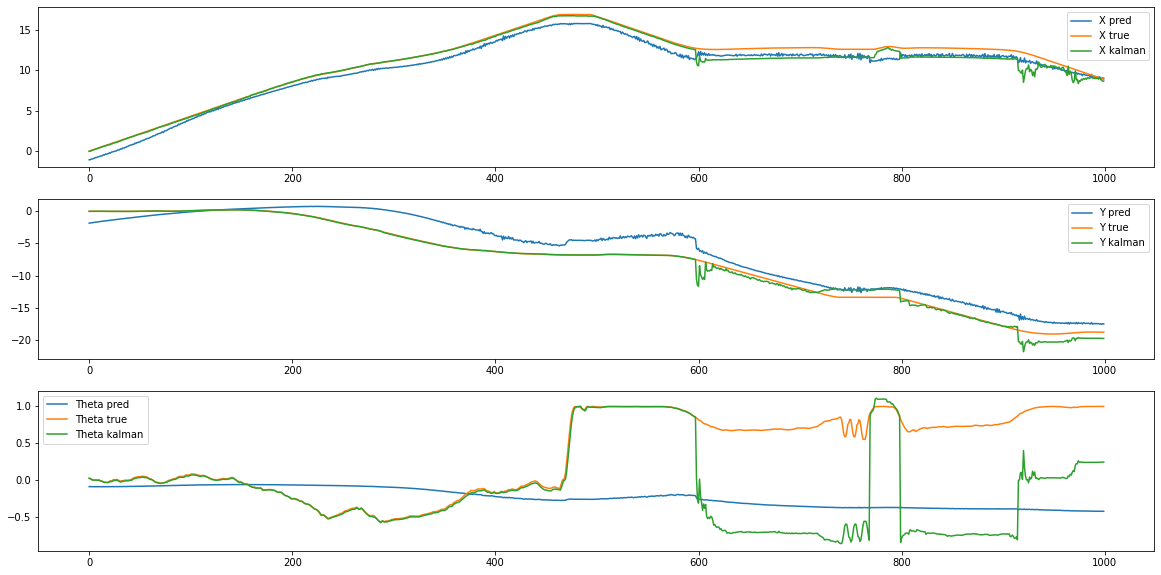

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading RNN model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-03_23-37-56/train_ray_04ca3_00003_3_lr=0.0007,num_layers=2,sequence_length=28_2023-05-03_23-47-16...
Test loss: 97.67289330703872
NN MSE: [71.06204105533791, 221.70071270484678, 0.25591876283739773], 71.06204105533791
KF MSE: [17.77573435384391, 143.82167838172418, 0.10664544740788669], 17.77573435384391


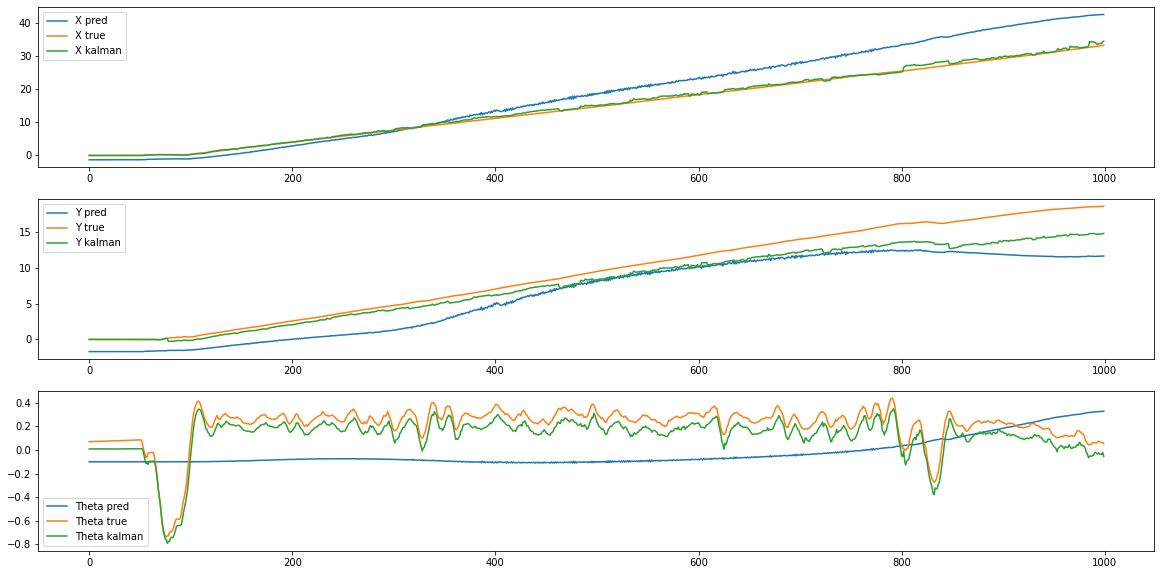

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading RNN model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-03_23-37-56/train_ray_04ca3_00003_3_lr=0.0007,num_layers=2,sequence_length=28_2023-05-03_23-47-16...
Test loss: 62.41750606737639
NN MSE: [127.71573996661935, 58.64063579348706, 0.8961419756618612], 127.71573996661935
KF MSE: [14.212498990049044, 38.88064932965862, 0.10207701358337826], 14.212498990049044


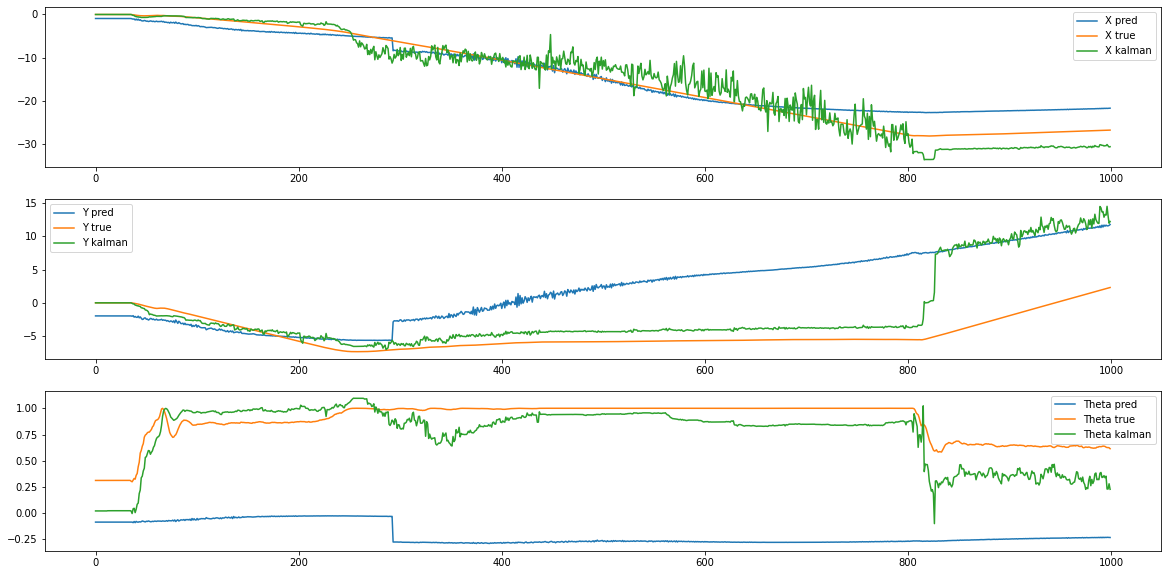

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading RNN model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-03_23-37-56/train_ray_04ca3_00003_3_lr=0.0007,num_layers=2,sequence_length=28_2023-05-03_23-47-16...
Test loss: 1.010227375626564
NN MSE: [0.8795133366489972, 1.7241887313953996, 0.4269801042346262], 0.8795133366489972
KF MSE: [0.19424027079421535, 0.18997303008912253, 0.47563832569416964], 0.19424027079421535


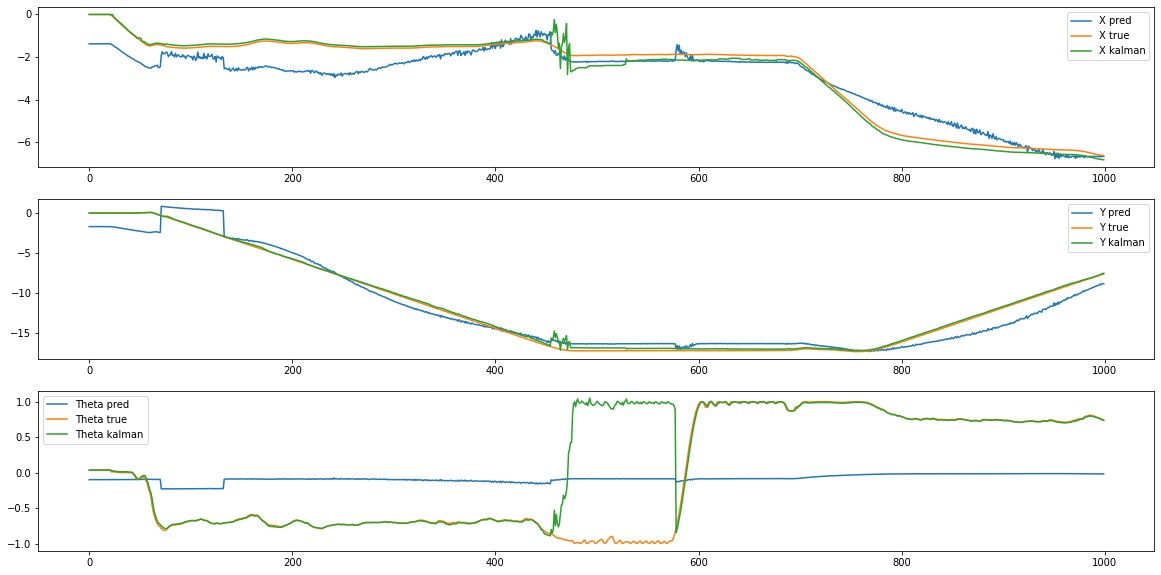

Total Kalman MSe  \
Test model Test set                                                               
RNN        data/2D/evaluation_data/intel_alpha_8_run_2_mer...          0.575866   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...         17.775734   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...         14.212499   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...          0.194240   

                                                               Total NN MSE  \
Test model Test set                                                           
RNN        data/2D/evaluation_data/intel_alpha_8_run_2_mer...      1.156377   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...     71.062041   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...    127.715740   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.879513   

                                                               Kalman MSE X  \
Test model Test set                                                           
RNN        data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.575866   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...     17.775734   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...     14.212499   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.194240   

                                                                 NN MSE X  \
Test model Test set                                                         
RNN        data/2D/evaluation_data/intel_alpha_8_run_2_mer...    1.156377   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...   71.062041   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...  127.715740   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...    0.879513   

                                                               Kalman MSE Y  \
Test model Test set                                                           
RNN        data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.290617   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...    143.821678   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...     38.880649   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.189973   

                                                                 NN MSE Y  \
Test model Test set                                                         
RNN        data/2D/evaluation_data/intel_alpha_8_run_2_mer...    2.837983   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...  221.700713   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...   58.640636   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...    1.724189   

                                                               Kalman MSE Theta  \
Test model Test set                                                               
RNN        data/2D/evaluation_data/intel_alpha_8_run_2_mer...          0.823670   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...          0.106645   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...          0.102077   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...          0.475638   

                                                               NN MSE Theta  
Test model Test set                                                          
RNN        data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.856227  
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...      0.255919  
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...      0.896142  
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.426980

In [24]:
data_dim = 2
model_name = "RNN"
# eval_csv_dir = "data/1D/evaluation_data/mnst_2_lnstd_0.1.csv"
eval_dir_path = f"data/{data_dim}D/evaluation_data"
eval_csv_dir = os.path.join(eval_dir_path, os.listdir(eval_dir_path)[0])
# json_config_path = '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_1D/best_config_RNN.json'
json_config_path = f'/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_{data_dim}D/best_config_{model_name}.json'


params = {
    "batch_size": 100,
    "model_name": model_name,
    "input_size": 19 if data_dim == 2 else 9,
    "output_size": 3 if data_dim == 2 else 1,
    'model_name': model_name,
    'data_dim': data_dim,
}


kalman_mse_x = []
kalman_mse_y = []
kalman_mse_theta = []

nn_mse_x = []
nn_mse_y = []
nn_mse_theta = []

kalman_mse_total = []
nn_mse_total = []

test_set = []
test_model = []

for csv_name in os.listdir(eval_dir_path):
    csv_dir = os.path.join(eval_dir_path, csv_name)
    print(f"CSV: {eval_csv_dir}")
    # get_csv_results(csv_dir)

    kf_loss_dims, kf_loss, nn_loss_dims, nn_loss = get_csv_results(csv_dir, params)

    kalman_mse_total.append(kf_loss)
    nn_mse_total.append(nn_loss)

    kalman_mse_x.append(kf_loss_dims[0])
    kalman_mse_y.append(kf_loss_dims[1])
    kalman_mse_theta.append(kf_loss_dims[2])

    nn_mse_x.append(nn_loss_dims[0])
    nn_mse_y.append(nn_loss_dims[1])
    nn_mse_theta.append(nn_loss_dims[2])

    test_set.append(csv_dir)
    test_model.append(model_name)


    print("====================================")
    print("====================================")
    print("====================================")


results_dict = {
    "Test set": test_set,
    "Test model": test_model,
    "Total Kalman MSe": kalman_mse_total,
    "Total NN MSE": nn_mse_total,
    "Kalman MSE X": kalman_mse_x,
    "NN MSE X": nn_mse_x,
    "Kalman MSE Y": kalman_mse_y,
    "NN MSE Y": nn_mse_y,
    "Kalman MSE Theta": kalman_mse_theta,
    "NN MSE Theta": nn_mse_theta,
}

pd.DataFrame.from_dict(results_dict).set_index(['Test model', 'Test set'])